## Lab Assignment 1 Scientific Computing

In [2]:
import numpy as np
from scipy.sparse import diags

from matplotlib import pyplot as plt
from matplotlib import animation,rc
from mpl_toolkits.mplot3d.axes3d import Axes3D

from IPython.display import HTML
rc('animation',html='html5')

from scipy.special import erfc

from numba import jit

import imageio

### 1.2 Vibrating String

In [ ]:
# matrix with (part of) discretized terms in wave equation
@jit
def wave_discr_matrix(dt, L, N, x0, xL):
    dx = L / N
    diagonals = [[1] * (N - 2) + [0], [0] + [-2] * (N - 2) + [0], [0] + [1] * (N - 2)]
    u_matrix = diags(diagonals, [-1, 0, 1]).toarray()
    return u_matrix

# function which returns next state vector based on previous and current
@jit
def time_step(discr_matrix, previous_vector, current_vector, c, dt, dx):
    
    next_state = ((c**2 * dt**2) / dx**2) * np.dot(discr_matrix, current_vector) - previous_vector + 2 * current_vector 
    return next_state

# constants
L = 1
N = 100
dx = L/N
dt = 0.001
t_end = 1.0
timesteps = int(t_end / dt)
c = 1

# create vector with initial amplitudes on each x position
x_vector = np.array([i for i in np.arange(0, L + L / N, L/N)]).reshape([N+1,1])

#choose initial state
init_state = 1

if init_state == 1:
    current_state = np.array([np.sin(2 * np.pi * x) for x in x_vector])
    title_label = "Vibrating string for $\sin(2\pi x)$"
elif init_state == 2:
    current_state = np.array([np.sin(5 * np.pi * x) for x in x_vector])
    title_label = "Vibrating string for $\sin(5\pi x)$"
else:
    current_state = np.array([np.sin(5 * np.pi * x) if 1/5<x<2/5 else 0 for x in x_vector])
    title_label = "Vibrating string for $\sin(5\pi x)$ between 0.2 and 0.4"

previous_state = current_state

# discretized matrix
discr_matrix = wave_discr_matrix(1, 1, current_state.shape[0], 0, 0)

# find a series of next states and plot
# First set up the figure, the axis, and the plot element we want to animate
# make figure to plot in


fig, ax = plt.subplots(figsize=(10,8))
line, = ax.plot(x_vector, current_state)
ax.set_ylim([-1.05,1.05])

plot, ax_plot = plt.subplots(figsize=(10,8))
ax.set_title(title_label)
ax.set_xlabel("x")

# initialization function: plot the background of each frame
def init():
    line.set_ydata(np.ma.array(x_vector,mask=True))
    return line,

# animation function.  This is called sequentially
def animate(i):
    global previous_state, current_state
    new_state = time_step(discr_matrix, previous_state, current_state, c, dt, dx)
    previous_state = current_state
    current_state = new_state
    line.set_ydata(new_state)
    if i % int(0.9 * timesteps/5) == 0:
        #add state 5 times to plot throughout time
        ax_plot.plot(x_vector, current_state, label="t = %.2f"%(i*dt))
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
animation.FuncAnimation(fig, animate, init_func=init,
                               frames=timesteps, interval=50, blit=True)

In [ ]:
ax_plot.legend() #add legend to plot

#set labels
ax_plot.set_title(title_label)
ax_plot.set_xlabel("x")

plot.savefig("VibratingString_init%d.pdf"%init_state)

#show figure
plot

### 1.3 The Time Dependent Diffusion Equation

In [ ]:
def diffusion_analytic(ymin,ymax,dy,D,t,n):
    """
    Calculate analytic solution to diffusion equation
    
    Show plot and return state at time t    
    """
    N = int((ymax - ymin) / dy)
    state = np.zeros([N+1,N+1])
    for j in range(0,N+1):
        y = ymax - j * dy
        state[j,:] = np.sum([erfc((1-y+2*i)/(2*np.sqrt(D*t)))\
                             -erfc((1+y+2*i)/(2*np.sqrt(D*t))) for i in range(n)])
        
    return state

ymin = 0
ymax = 1
dx = 0.05
D = 1
t = 0.1
n = 10

state = diffusion_analytic(ymin,ymax,dx,D,t,n)
fig, ax = plt.subplots(figsize=(10,10))
cax = ax.imshow(state,extent=[0,1,0,1])
fig.colorbar(cax)
ax.set_title("Analytic solution to the diffusion equation at t = %.3f"%t)
fig.savefig("Timedep_%.3f.pdf"%t)
fig

In [ ]:
@jit
def diff_timestep(dt,dx,D,cur):
    """
    Performs a single timestep of the diffusion equation    
    """
    N = cur.shape[0]
    next_timestep = cur.copy()
    for i in range(1,N-1):
        for j in range(0,N):
            left = j-1 if not j==0 else N-1
            right = j+1 if not j==N-1 else 0
            next_timestep[i,j] = cur[i,j] + (dt * D)/(dx**2) * (cur[i-1,j]+cur[i+1,j]+cur[i,right]+cur[i,left]-4*cur[i,j])
    return next_timestep

def time_dep_diffusion(dt,dx,D,cur,tend):
    """
    Performs 2D diffusion from t = 0 to t = tend
    
    """
    
    t = 0
    while t < tend:
        cur = diff_timestep(dt,dx,D,cur)
        t += dt
    return cur

In [ ]:
def MSE_timedep_diffusion(cur,dt,ymin,ymax,dy,D,t_end):
    n = 25
    t = 0
    
    MSE_list = []
    time_list = []
    
    while t <= t_end:
        t += dt
        true = diffusion_analytic(ymin,ymax,dy,D,t,n)
        cur = diff_timestep(dt,dy,D,cur)
        MSE = sum((true[:,1]-cur[:,1])**2)
        
        time_list.append(t)
        MSE_list.append(MSE)
    
    return time_list, MSE_list

N = 20
D = 1
t_end = 0.25
dt = 0.000625
dx = 1/N
initial = np.zeros([N+1,N+1])
initial[0,:] = 1

fig, ax = plt.subplots(figsize=(10,10))
time_list, MSE_list = MSE_timedep_diffusion(initial,dt,0,1,dx,D,t_end)
ax.semilogy(time_list, MSE_list)
ax.set_title("Error over time for time-dependent diffusion")
ax.set_xlabel("Time")
ax.set_ylabel("Sum of error squared")
ax.grid()
fig.savefig("MSE_timedep.pdf")
fig

In [ ]:
N = 20
D = 1
t_end = 0.25
dt = 0.000625
dx = 1/N
x = np.arange(0,1+dx,dx)

initial = np.zeros([N+1,N+1])
initial[0,:] = 1

assert 4*dt*D/(dx**2) <= 1,"Scheme is unstable for chosen values!"

fig, ax = plt.subplots(figsize=(10,10))
cur = initial
im = ax.imshow(cur, extent = [0,1,0,1])
cb = fig.colorbar(im)
tx = ax.set_title('t = %.3f'%(0))
ax.set_xlabel("x")
ax.set_ylabel("y")

plot, ax_plot = plt.subplots()

def animate(i):
    global cur
    if i % int(timesteps/6) == 0:
        ax_plot.plot(x[::-1],cur[:,0],label="t = %.2f"%(i * dt))
    cur = diff_timestep(dt,dx,D,cur)
    im.set_data(cur)
    im.set_clim(0,1) 
    tx.set_text("t = %.3f"%(i * dt))
    
def init():
    return
    
timesteps = int(t_end / dt)
animation.FuncAnimation(fig,animate,init_func=init,frames=timesteps,interval=20)

In [ ]:
ax_plot.legend() #add legend to plot

#set labels
ax_plot.set_title("Diffusion over time on the y-axis")
ax_plot.set_xlabel("y")
ax_plot.set_ylabel("Concentration")
ax_plot.grid()

plot.savefig("DiffusionOverTime.pdf")

#show figure
plot             

## The Jacobi Iteration

In [ ]:
@jit
def jacobi(dx,D,cur,epsilon):
    """
    Performs Jacobi iteration until convergence
    """
    
    dt = (1/4) * dx**2 / D
    
    
    #need to have next timestep to enter while-loop
    next_timestep = diff_timestep(dt,dx,D,cur) 
    
    #init at 1, as we have already done one iteration
    i = 1
    
    #loop until convergence to specified accuracy
    while not (abs(next_timestep - cur) < epsilon).all():
        cur = next_timestep
        next_timestep = diff_timestep(dt,dx,D,cur)
        i += 1
        
    return next_timestep, i

In [ ]:
N = 50
D = 1
dx = 1/N
initial = np.zeros([N+1,N+1])
initial[0,:] = 1
cur = initial

%time arr,_ = jacobi(dx,D,cur,0.000001)

fig, ax = plt.subplots()
ax.imshow(arr, extent = [0,1,0,1])
ax.set_title("Jacobi Iteration")
ax.set_xlabel("x")
ax.set_ylabel("y")
fig

# Gauss-Seidel Iteration

In [ ]:
@jit
def diff_timestep_gs(cur, epsilon):
    """
    Performs a single timestep of the diffusion equation for
    Gauss-Seidel iterative method
    """
    N = cur.shape[0]
    conv_bool = True 
    for i in range(1,N-1):
        for j in range(0,N):
            prev = cur[i,j]
            left = j-1 if not j==0 else N-1
            right = j+1 if not j==N-1 else 0
            cur[i,j] = 1/4 * (cur[i-1,j]+cur[i+1,j]+cur[i,right]+cur[i,left])
            
            # convergence condition
            if abs(prev-cur[i,j]) > epsilon:
                conv_bool = False        
    return cur, conv_bool

def gauss_seidel(cur,epsilon):
    """
    Performs Gauss-Seidel iteration until convergence
    """
    i = 0
    conv_bool = False
    
    while not conv_bool:
        cur, conv_bool = diff_timestep_gs(cur, epsilon)
        i += 1
    
    return cur, i 

In [ ]:
N = 50
initial = np.zeros([N+1,N+1])
initial[0,:] = 1
cur = initial

%time arr,_ = gauss_seidel(cur,0.0001)

fig, ax = plt.subplots()
ax.imshow(arr, extent = [0,1,0,1])
ax.set_title("Gauss-Seidel Iteration")
ax.set_xlabel("x")
ax.set_ylabel("y")
fig

## Successive Over Relaxation

In [7]:
@jit
def diff_timestep_sor(cur, epsilon, omega):
    """
    Performs a single timestep of the diffusion equation for
    Successive Over Relaxation method
    """
    N = cur.shape[0]
    conv_bool = True  
   
    # iterate over the domain
    for i in range(1,N-1):
        for j in range(0,N):
            prev = cur[i,j]
            left = j-1 if not j==0 else N-1
            right = j+1 if not j==N-1 else 0

            cur[i,j] = omega/4 * (cur[i-1,j]+cur[i+1,j]+cur[i,right]+cur[i,left])\
                   + (1-omega) * cur[i,j]
            
            # convergence condition
            if abs(prev-cur[i,j]) > epsilon:
                conv_bool = False  
    return cur, conv_bool

def sor(cur, epsilon, omega, image=None):
    """
    Performs successive over relaxation until convergence
    """
    
    conv_bool = False
    i = 0
    
    if image is None:
        while not conv_bool:
            cur, conv_bool = diff_timestep_sor(cur, epsilon, omega)
            i += 1
    else:
        while not conv_bool:
            cur, conv_bool = diff_timestep_sor_img(cur, epsilon, omega, image)
            i += 1
    return cur, i
            

### Obtain optimal omega for SOR

In [ ]:
#need this for interactive 3d plotting!
%matplotlib notebook

#create figure
fig = plt.figure()

# set up the axes
ax = fig.add_subplot(1, 1, 1, projection='3d')

# create surface
x = np.arange(1.4, 1.99, 0.005)
y = np.arange(5, 60, 1)
x, y = np.meshgrid(x, y)

# obtain z-values
z = np.zeros(x.shape)
for i in range(x.shape[0]):
    for j in range(y.shape[1]):
        N = y[i,j]
        omega = x[i,j]
        initial = np.zeros([N+1,N+1])
        initial[0,:] = 1
        cur = initial
        epsilon = 0.00001
        
        _, z[i,j] = sor(cur,epsilon,omega)

#obtain line of minima
N_list = []
iter_list = []
omega_list = []
for i in range(z.shape[0]):
    N_list.append(y[i,0])
    iter_list.append(min(z[i,:]))
    omega_list.append(x[i,np.argmin(z[i,:])])

#plot wireframe and minimum values
ax.plot_wireframe(x,y,z, rstride=3, cstride=3)
ax.plot(omega_list,N_list,iter_list,'r',label="Optimal $\omega$")
ax.set_xlabel("$\omega$")
ax.set_ylabel("N")
ax.set_zlabel("Iterations")

#add legend
ax.legend()

#better initial view
ax.view_init(elev=39, azim=-133)

fig.savefig("optimalomega3d.pdf");

In [ ]:
#print optimal omega and #iter for each N
for i in range(len(N_list)):
    print("N: %d, omega: %.3f, iterations: %d"%(N_list[i], omega_list[i], iter_list[i]))

#show N against omega
fig, ax = plt.subplots()
ax.plot(N_list,omega_list)

ax.set_title("$\omega$ as function of N")
ax.set_xlabel("N")
ax.set_ylabel("Optimal $\omega$")
ax.grid()

fig.savefig("omegaN.pdf")

#show N against #iter
fig, ax = plt.subplots()
ax.plot(N_list,iter_list)

ax.set_title("Number of iterations needed as function of N")
ax.set_xlabel("N")
ax.set_ylabel("Number of iterations")
ax.grid()

fig.savefig("omegaIterations.pdf")

In [ ]:
from scipy.optimize import curve_fit

def fit_func(x, a, b, c):
    return a * x ** b + c

popt, _ = curve_fit(fit_func, omega_list, N_list)

fig,ax = plt.subplots()
xdata = np.arange(1.7,1.93,0.01)

ax.plot(fit_func(xdata, *popt),xdata,label='Fitted data')
ax.plot(N_list, omega_list, "r", label='Original data')
ax.legend()
ax.set_title("Fitting optimal omega as function of N")
ax.set_xlabel("N")
ax.set_ylabel('$\omega$')
fig.savefig("omegaFit.pdf")

### Compare the three methods

In [ ]:
N = 50
omega = 1.92
initial = np.zeros([N+1,N+1])
initial[0,:] = 1
cur = initial

epsilon_list = []
jacobi_list = []
gauss_seidel_list = []
sor_list = []

for i in np.arange(1,8,0.05):
    epsilon = 10 ** (-i)
    epsilon_list.append(i)
    _, jacobi_res = jacobi(1/N, 1, cur.copy(), epsilon)
    _, gauss_seidel_res = gauss_seidel(cur.copy(), epsilon)
    _, sor_res = sor(cur.copy(), epsilon, omega)
    jacobi_list.append(jacobi_res)
    gauss_seidel_list.append(gauss_seidel_res)
    sor_list.append(sor_res)
    
fig, ax = plt.subplots()
ax.plot(epsilon_list, jacobi_list, label="Jacobi Iteration")
ax.plot(epsilon_list, gauss_seidel_list, label="Gauss-Seidel Iteration")
ax.plot(epsilon_list, sor_list, label="Successive OverRelaxation")
ax.grid()
ax.legend()
ax.set_title("Number of iterations for all three methods")
ax.set_xlabel('p ($\epsilon$ = $10^{-p}$)')
ax.set_ylabel("Number of iterations")
#try to obtain style as in lecture
#https://stackoverflow.com/a/11579834
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.yaxis.major.formatter._useMathText = True
fig.savefig("ComparisonTimeIndep.pdf")

In [ ]:
N = 50
initial = np.zeros([N+1,N+1])
initial[0,:] = 1
cur = initial
%time arr, _ = sor(cur,0.0001, 1.92)
fig, ax = plt.subplots()
ax.imshow(arr, extent = [0,1,0,1])
ax.set_title("Successive OverRelaxation")
ax.set_xlabel("x")
ax.set_ylabel("y");
# fig.savefig("SORresult.pdf")

In [ ]:
# compute difference compared to analytical solution (to do)
def MSE(result):
    return sum(abs(np.linspace(1,0,N+1)-result[:,1])**2)

N = 50
initial = np.zeros([N+1,N+1])
initial[0,:] = 1

epsilon = 1E-4

print("Errors for the three methods with epsilon = %.2e"%epsilon)
jac_res,_ = jacobi(1/N,1,initial.copy(),epsilon)
print("Jacobi: %.5e"%(MSE(jac_res)))
gs_res,_ = gauss_seidel(initial.copy(),epsilon)
print("Gauss-Seidel: %.5e"%(MSE(gs_res)))
sor_res,_ = sor(initial.copy(),epsilon,1.92)
print("SOR: %.5e"%(MSE(sor_res)))
fig,ax = plt.subplots()
x = np.arange(0,1.02,0.02)

#use x[::-1] to show correct y-values
ax.plot(x[::-1],jac_res[:,0],label="Jacobi")
ax.plot(x[::-1],gs_res[:,0],label="Gauss-Seidel")
ax.plot(x[::-1],sor_res[:,0],label="Successive OverRelaxation")
ax.set_title("Convergence to y=x for the three methods")
ax.set_xlabel("y")
ax.set_ylabel("concentration")
ax.grid()
ax.legend();

## Adding an Object to the Domain

In [3]:
@jit
def diff_timestep_sor_img(cur, epsilon, omega, image):
    """
    Performs a single timestep of the diffusion equation for
    Successive Over Relaxation method
    """
    N = cur.shape[0]
    conv_bool = True 
    
    # read image
    assert cur.shape == image.shape, "Cur and Image have to be the same size!"
        
    # iterate over the domain
    for i in range(1,N-1):
        for j in range(0,N):
            prev = cur[i,j]
            left = j-1 if not j==0 else N-1
            right = j+1 if not j==N-1 else 0
            
            if image[i,j] == True:
                cur[i,j] = 0
            else:
                cur[i,j] = omega/4 * (cur[i-1,j]+cur[i+1,j]+cur[i,right]+cur[i,left])\
                       + (1-omega) * cur[i,j]
            
            # convergence condition
            if abs(prev-cur[i,j]) > epsilon:
                conv_bool = False  
    return cur, conv_bool

In [4]:
# images: object_three_sq.jpg, object_circle.jpg, object_weird_shape.jpg, object.jpg
image = 'object.jpg'

object_array = imageio.imread(image, pilmode='L')
fig, ax = plt.subplots()
ax.imshow(object_array, cmap='gray');

In [5]:
# true for object parts
object_array = imageio.imread(image, pilmode='L') #re-read, as we modify 'in-place'
object_array[object_array<=127] = True
object_array[object_array>=128] = False
object_array = np.array(object_array.astype(bool))
# object_array[20,20]

CPU times: user 9.41 ms, sys: 370 µs, total: 9.78 ms
Wall time: 9.77 ms


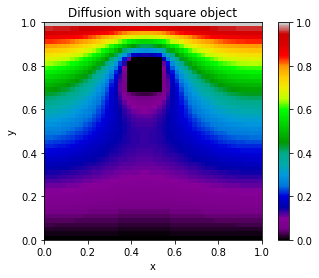

In [11]:
%matplotlib inline
N = 49 #50-1, as we want 50 points, including initial and endpoint
initial = np.zeros([N+1,N+1])
initial[0,:] = 1
cur = initial
%time arr, _ = sor(cur,1E-10, 1.92, object_array)
fig, ax = plt.subplots()
# im = ax.imshow(arr, extent = [0,1,0,1], cmap='gist_rainbow')

# some colormaps: gist_stern, nipy_spectral, 

im = ax.imshow(arr, extent = [0,1,0,1], cmap='nipy_spectral')

cb = plt.colorbar(im)
if image == 'object_circle.jpg':
    ax.set_title("Diffusion with circular object")
    save_file = 'diffusion_circle.pdf'
elif image == 'object_three_sq.jpg':
    ax.set_title("Diffusion with three square objects")
    save_file = 'diffusion_three_sq.pdf'
elif image == 'object.jpg':
    ax.set_title("Diffusion with square object")
    save_file = 'diffusion_square.pdf'
else:
    ax.set_title("Diffusion with some object")
    save_file = 'diffusionobject.pdf'
ax.set_xlabel("x")
ax.set_ylabel("y")

fig.savefig(save_file)

In [9]:
fig, ax = plt.subplots()
ax.plot(arr[:,20]);


#### Comparing omega and number of iterations with(out) object

In [ ]:
sor_list = []
img_list = []
omega_list = []

N = 49
epsilon = 1E-5
for omega in np.arange(1.7,1.99,0.001):
    initial = np.zeros([N+1,N+1])
    initial[0,:] = 1
    
    _, i_sor = sor(initial.copy(),epsilon,omega)
    _, i_img = sor(initial.copy(),epsilon,omega,object_array)
    
    sor_list.append(i_sor)
    img_list.append(i_img)
    omega_list.append(omega)
fig, ax = plt.subplots()
ax.plot(omega_list, sor_list, label="SOR without object")
ax.plot(omega_list, img_list, label="SOR with object")
ax.grid()
ax.legend()
ax.set_title("Comparing $\omega$ and number of iterations with(out) object")
ax.set_xlabel("$\omega$")
ax.set_ylabel("Number of iterations")
fig.savefig("OmegaIterWithObject.pdf")

print("Optimal omega without object: %.3f (%d iterations)"%(omega_list[np.argmin(sor_list)],np.min(sor_list)))
print("Optimal omega with object: %.3f (%d iterations)"%(omega_list[np.argmin(img_list)],np.min(img_list)))